We use preprocessing functions and utilities from the earlier work done here: https://github.com/sydney-machine-learning/COVID19_sentinentanalysis

## **EDA**

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
import string
from textblob import TextBlob
from nltk.corpus import stopwords
!pip install demoji
nltk.download('all')
import demoji
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

In [33]:
pd.options.display.max_colwidth = 250

In [34]:
#!pip install --upgrade transformers==4.10.1
!pip install transformers

In [35]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
import torchtext
from torchtext import data

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [36]:
print(transformers.__version__)

4.38.2


In [37]:
!git clone https://github.com/sydney-machine-learning/COVID19_sentinentanalysissocialmedia

fatal: destination path 'COVID19_sentinentanalysissocialmedia' already exists and is not an empty directory.


In [38]:
demoji.download_codes()

In [39]:
senwave = pd.read_csv("/content/drive/MyDrive/sbg_miniproject/labeledEn.csv")
print("Length of Senwave Dataset = {}".format(len(senwave)))

Length of Senwave Dataset = 10000


In [40]:
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking
0,1.245140e+18,A glass of wine keeps the corona away- DRAKE. No se diga ms cheers to that,1,0,0,0,0,0,0,0,0,1
1,1.245140e+18,Can Anyone tell me if you took the flu shot last year will it give you a positive result for Coronavirus even if you dont have it???,0,0,0,0,1,0,0,0,0,0
2,1.245140e+18,Btw producers send me beats Im working on music and smoke loud as we speak to get thru coronavirus pandemic,1,0,0,0,0,0,0,0,0,1
3,1.245140e+18,When someone you know.. apart of your family dies from the Coronavirus its shocking unexplainable. My whole day has been down.,0,0,0,0,0,1,0,0,0,0
4,1.245140e+18,"Dear soccer, I really miss you ,please come back already :( Also dear corona , Frick u for ruining everything",0,0,0,0,0,1,1,0,0,0
5,1.245140e+18,new home remedy to treat coronavirus! tested by leading officials at the white house,1,0,0,0,0,0,0,1,0,1
6,1.245140e+18,"When Xavier Wulf does an Attack on Titan tape like he did Project X for Initial D, the coronavirus will officially disappear",0,0,0,0,0,0,0,0,0,1
7,1.245140e+18,Mouthwash is hand san for your mouth and I don't know how to feel about it ShowerThoughts StayAtHome coronavirus,0,0,0,0,0,1,0,0,0,1
8,1.245140e+18,Yes all of them ! n France 1.000 Christians took the Coronavirus from a Sunday Church meeting !,0,0,0,0,0,0,1,0,1,0
9,1.245140e+18,Update I destroyed the tire honestly if I get corona virus because of what just happened I deserved it,0,0,0,1,0,1,0,0,0,0


[2373, 498, 389, 1325, 1695, 2133, 3492, 631, 1207, 4476]


Text(0.5, 0, 'Count')

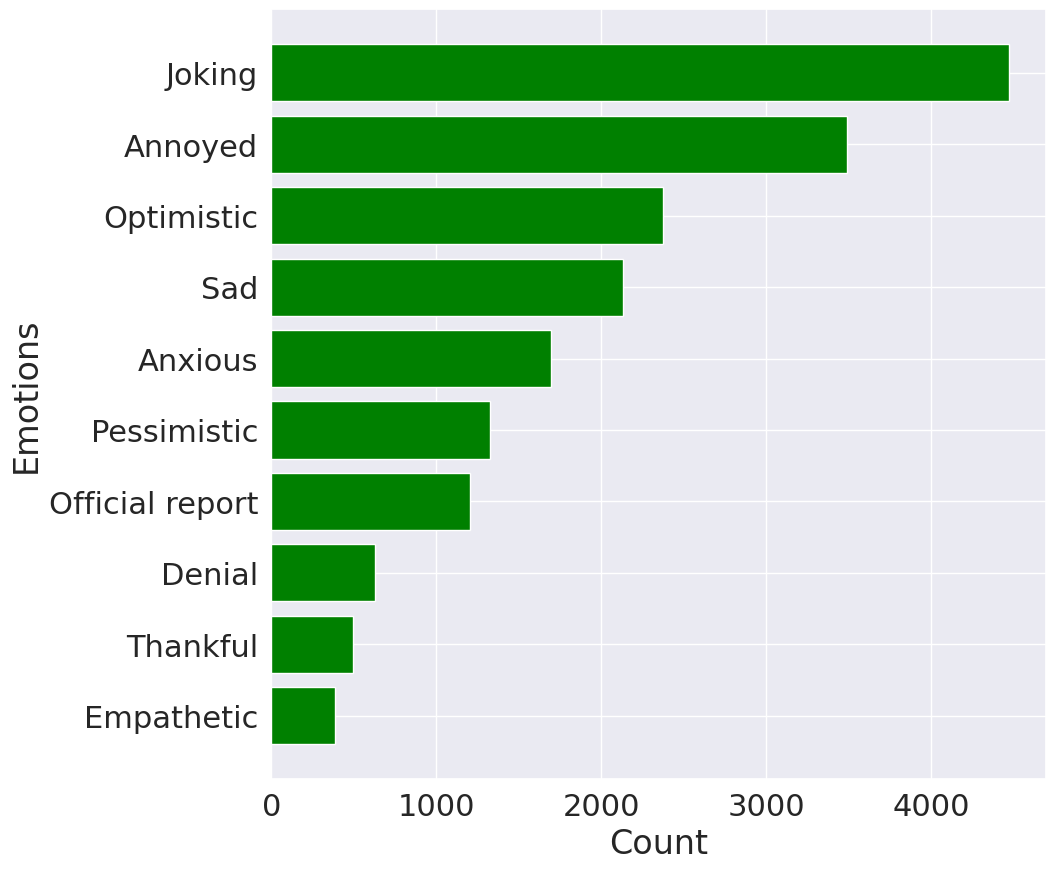

In [41]:
emotions = list(senwave.columns[2:])
scores = [sum(senwave[x]) for x in emotions]
print(scores)
pairs = []

for i in range(len(emotions)):
    pairs.append((emotions[i], scores[i]))

pairs = sorted(pairs, key = lambda x : x[1], reverse = False)
emotions_sorted = []
scores_sorted = []

for pair in pairs:
    emotions_sorted.append(pair[0])
    scores_sorted.append(pair[1])

fig = plt.figure(figsize = (10, 10))
plt.barh(emotions_sorted, scores_sorted, color = 'green')
plt.ylabel("Emotions")
plt.xlabel("Count")

In [42]:
rand_idx = np.random.randint(0, len(senwave))
print("Tweet : ", senwave.iloc[rand_idx]['Tweet'])
for e in emotions:
    print(e, ": ", senwave.iloc[rand_idx][e])

Tweet :  Its April fools, yall can say April fools towards this whole coronavirus thing now
Optimistic :  0
Thankful :  0
Empathetic :  0
Pessimistic :  1
Anxious :  0
Sad :  0
Annoyed :  0
Denial :  0
Official report :  0
Joking :  1


In [43]:
only_emotes = senwave[emotions]

In [44]:
only_emotes

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking
0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,0,0,0,0,0,1
9996,1,1,0,0,1,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0
9998,1,0,0,1,0,0,0,0,0,1


In [45]:
len(only_emotes)

10000

In [46]:
emote_array = np.zeros((10, 10))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7, 'Official report' : 8,
     'Joking' : 9
}
for i in range(len(only_emotes)):
    l = only_emotes.iloc[i].tolist()
    for j in range(10):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 10):                 # to avoid double counting.
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

In [47]:
len(only_emotes)

10000

In [48]:
emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)
emote_df

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking
0,2373,235,171,226,246,291,379,72,156,982
1,235,498,28,15,41,29,67,14,70,92
2,171,28,389,18,50,71,41,7,7,63
3,226,15,18,1325,268,272,420,90,62,554
4,246,41,50,268,1695,360,452,95,138,510
5,291,29,71,272,360,2133,723,54,186,747
6,379,67,41,420,452,723,3492,261,122,1235
7,72,14,7,90,95,54,261,631,51,184
8,156,70,7,62,138,186,122,51,1207,95
9,982,92,63,554,510,747,1235,184,95,4476


<Axes: >

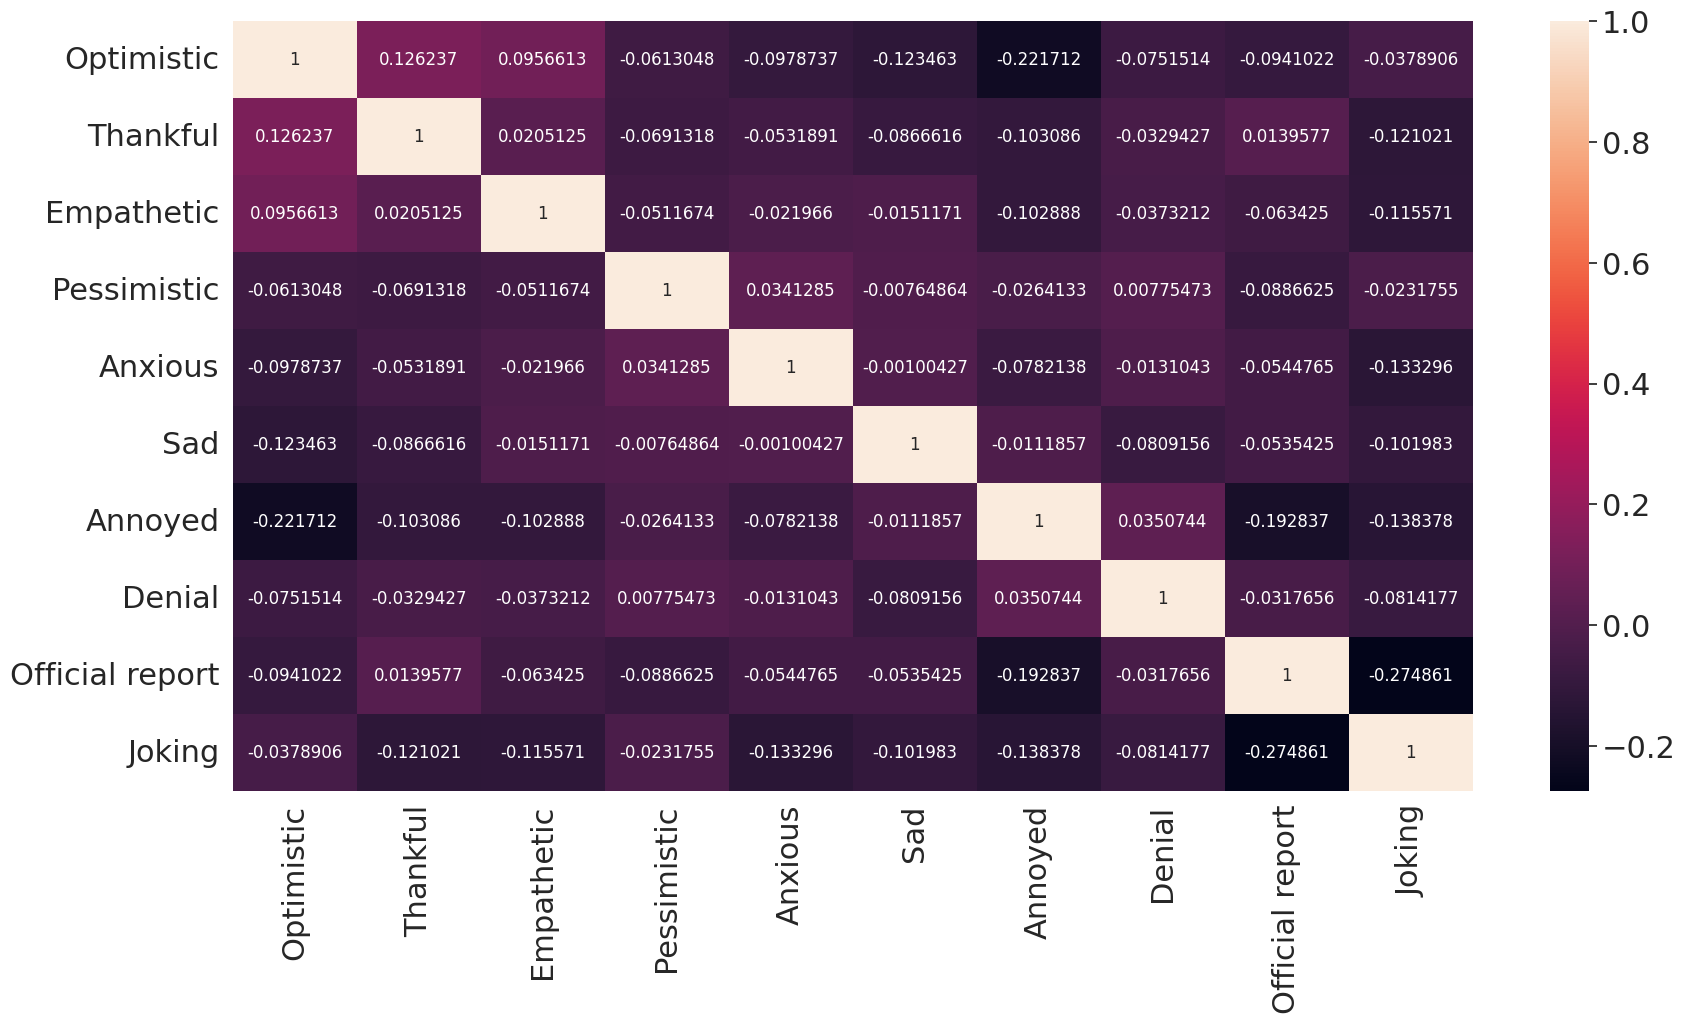

In [49]:
fig = plt.figure(figsize = (20, 10))
sns.heatmap(only_emotes.corr(), annot = True, xticklabels = emote_df.columns, yticklabels = emote_df.columns, fmt = 'g', annot_kws = {"size" : 12})

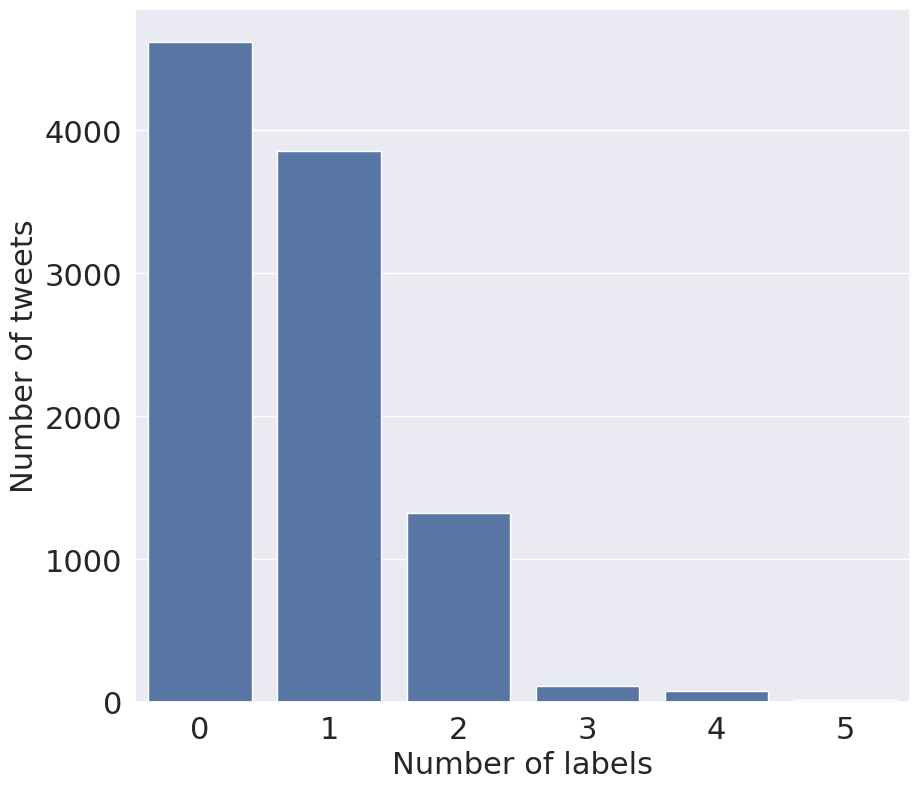

In [50]:
senwave['n_emotions'] = senwave['Optimistic'] + senwave['Thankful'] + senwave['Empathetic'] + senwave['Pessimistic'] + senwave['Anxious'] + senwave['Sad'] + senwave['Annoyed'] +\
                        senwave['Official report']  + senwave['Joking']
rowSums = senwave['n_emotions']
multiLabel_counts = rowSums.value_counts()

sns.set(font_scale = 2)
plt.figure(figsize = (10, 9))

ax = sns.barplot(multiLabel_counts.values, orient = 'v')

#plt.title("Tweets having multiple labels")
plt.ylabel('Number of tweets', fontsize = 22)
plt.xlabel('Number of labels', fontsize = 22)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    #ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [51]:
multiLabel_counts

n_emotions
2    4617
1    3856
3    1323
4     111
0      76
5      17
Name: count, dtype: int64

<Axes: >

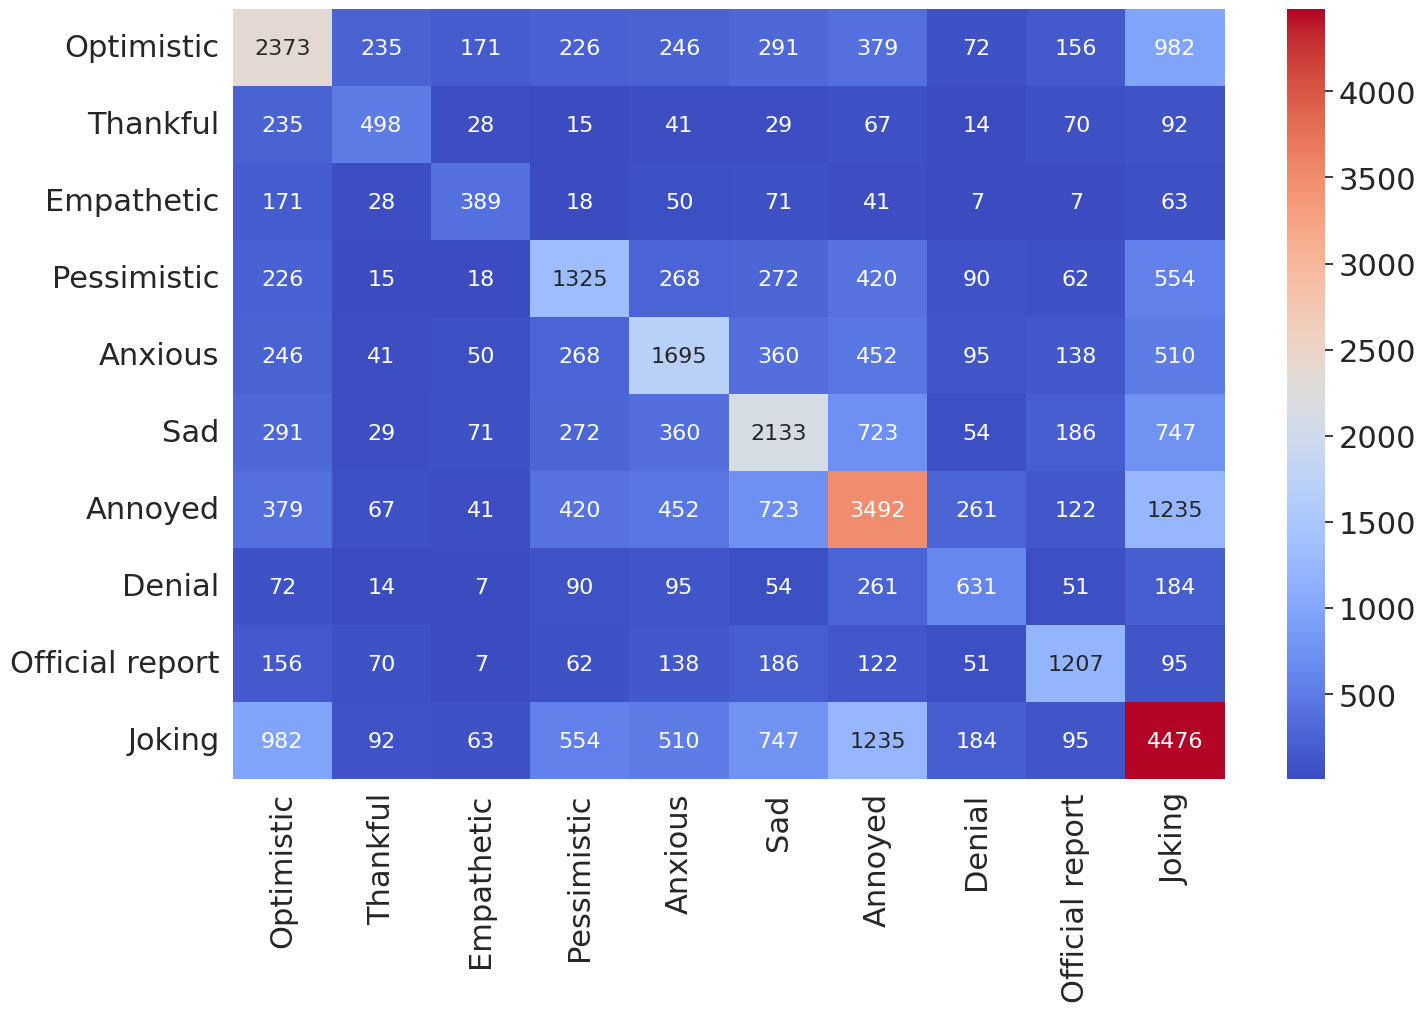

In [52]:
fig = plt.figure(figsize = (16,10))
sns.set(font_scale = 2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns,
            fmt = 'g', annot_kws = {"size" : 16})

**Cleaning followed by Unigram and Bigram analysis**

In [53]:
def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    StopWords = stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in StopWords]

In [54]:
words = clean(''.join(str(senwave['Tweet'].tolist())))

In [55]:
words[:20]

['glass',
 'wine',
 'keep',
 'corona',
 'away',
 'drake',
 'se',
 'diga',
 'm',
 'cheer',
 'anyone',
 'tell',
 'took',
 'flu',
 'shot',
 'last',
 'year',
 'give',
 'positive',
 'result']

# **Preprocessing**

In [56]:
contractions = {
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
"hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
"i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
"mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she shall / she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
"so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
"they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
"y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"
}

In [57]:
contractionsWithAnotherInvertedComma = {
"ain’t": "am not", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not",
"couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
"hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "he’s": "he is",
"how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
"i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would",
"it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us",
"ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
"mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have",
"shan’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will",
"she’ll’ve": "she will have", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
"so’ve": "so have", "so’s": "so is", "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",
"there’d’ve": "there would have", "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will",
"they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would",
"we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have",
"who’s": "who is", "who’ve": "who have", "why’s": "why is", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
"would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have",
"y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
"you’re": "you are", "you’ve": "you have"
}

In [58]:
class preprocess():
    def __init__(self, df, contractions, otherContractions):
        self.df = df
        self.contractions = contractions
        self.otherContractions = otherContractions

    def lower(self, tweet):
        return tweet.lower()

    def abbreviate(self, tweet):
        tweet = tweet.split(' ')
        j = 0
        for str_ in tweet:
            fileName = '/content/drive/MyDrive/sbg_miniproject/Abbreviations.txt'
            accessMode = 'r'
            with open(fileName, accessMode) as csvfile:
                dataFromFile = csv.reader(csvfile, delimiter = '=')
                str_ = re.sub('[^a-zA-Z0-9-_.]', '', str_)
                for row in dataFromFile:
                    if str_.upper() == row[0]:
                        tweet[j] = row[1]
                csvfile.close()
            j += 1
        return ' '.join(tweet)

    def expand(self, tweet):
        for word in tweet.split():
            if word in self.contractions.keys():
                tweet = tweet.replace(word, self.contractions[word])
            elif word in self.otherContractions.keys():
                tweet = tweet.replace(word, self.otherContractions[word])
        return tweet

    def emoji2text(self, tweet):
        emojis = demoji.findall(tweet)
        new_tweet = []
        for word in tweet.split():
            if word in emojis.keys():
                tweet = tweet.replace(word, emojis[word])
                new_tweet.append(emojis[word])
            wordmojis = demoji.findall(word)
            for char in word:
                if char in wordmojis.keys():
                    tweet = tweet.replace(word, wordmojis[char])

        return tweet

    def remove_hashtags(self, tweet):
        return re.sub(r'\#w+', '', tweet)

    def remove_mentions(self, tweet):
        for word in tweet.split():
            if word[0] == '@':
                tweet = tweet.replace(word, '')
        return tweet

    def remove_punctuations(self, tweet):
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        return tweet.translate(trantab)

    def preprocess_tweet(self, tweet):
        tweet = self.lower(tweet)
        tweet = self.abbreviate(tweet)
        tweet = self.expand(tweet)
        tweet = self.emoji2text(tweet)
        tweet = self.remove_mentions(tweet)
        tweet = self.remove_hashtags(tweet)
        tweet = self.remove_punctuations(tweet)
        return tweet

In [59]:
# from COVID19_sentinentanalysissocialmedia.preprocessing.preprocess import preprocess
pp_class = preprocess(senwave, contractions, contractionsWithAnotherInvertedComma)
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : pp_class.preprocess_tweet(x))

In [60]:
senwave['Tweet'] = senwave['Tweet'].str.lower()
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking,n_emotions
0,1.245140e+18,a glass of wine keeps the corona away drake no se diga ms cheers to that,1,0,0,0,0,0,0,0,0,1,2
1,1.245140e+18,can anyone tell me if you took the flu shot last year will it give you a positive result for coronavirus even if you dont have it,0,0,0,0,1,0,0,0,0,0,1
2,1.245140e+18,by the way producers send me beats im working on music and smoke loud as we speak to get thru coronavirus pandemic,1,0,0,0,0,0,0,0,0,1,2
3,1.245140e+18,when someone you know apart of your family dies from the coronavirus its shocking unexplainable my whole day has been down,0,0,0,0,0,1,0,0,0,0,1
4,1.245140e+18,dear soccer i really miss you please come back already also dear corona frick you for ruining everything,0,0,0,0,0,1,1,0,0,0,2
5,1.245140e+18,new home remedy to treat coronavirus tested by leading officials at the white house,1,0,0,0,0,0,0,1,0,1,2
6,1.245140e+18,when xavier wulf does an attack on titan tape like he did project x for initial d the coronavirus will officially disappear,0,0,0,0,0,0,0,0,0,1,1
7,1.245140e+18,mouthwash is hand san for your mouth and i do not know how to feel about it showerthoughts stayathome coronavirus,0,0,0,0,0,1,0,0,0,1,2
8,1.245140e+18,yes all of them n france 1 000 christians took the coronavirus from a sunday church meeting,0,0,0,0,0,0,1,0,1,0,2
9,1.245140e+18,update i destroyed the tire honestly if i get corona virus because of what just happened i deserved it,0,0,0,1,0,1,0,0,0,0,2


In [61]:
from COVID19_sentinentanalysissocialmedia.preprocessing import wordReplace
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : wordReplace.bruteGen(x))

# **Building the model followed by training & testing**

In [62]:
from sklearn.model_selection import train_test_split
sen_train, sen_test = train_test_split(senwave, train_size = 0.9, random_state = 1024)

sen_train.to_csv("train.csv", index = False)
sen_test.to_csv("test.csv", index = False)

In [63]:
sen_train.head(1)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking,n_emotions
560,1.245140e+18,minister for agriculture mahendra reddy to hold a press conference on coronavirus assistance the conference will be held at 12 30pm,0,0,0,0,0,0,0,0,1,0,1


In [64]:
!pip install spacy

In [65]:
import pandas as pd
import csv
import spacy
import re

# Load spaCy English tokenizer
spacy_en = spacy.load('en_core_web_sm')

# Tokenizer function
def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

# Read CSV using Python's CSV module
def read_csv(filename):
    data = []
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data.append(row)
    return data

# Load data
train_dataset = read_csv('/content/drive/MyDrive/sbg_miniproject/train_set.csv')
test_dataset = read_csv('/content/drive/MyDrive/sbg_miniproject/test_set.csv')

# Preprocess data and separate features and labels
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

# Tokenize tweet text
train_df['Tweet'] = train_df['Tweet'].apply(tokenizer)
test_df['Tweet'] = test_df['Tweet'].apply(tokenizer)

# Rename columns
label_columns = ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Joking']
train_df.rename(columns={'ID': 'ID'}, inplace=True)
test_df.rename(columns={'ID': 'ID'}, inplace=True)

# Split into X and y
X_train = train_df['Tweet']
X_test = test_df['Tweet']
y_train = train_df[label_columns]
y_test = test_df[label_columns]


In [ ]:
"""
import spacy
spacy_en = spacy.load('en_core_web_sm')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

TWEET = torchtext.data.Field(sequential = True, lower = True, tokenize = tokenizer)
LABEL = torchtext.data.Field(sequential = False, use_vocab = False)

dataFields = [("ID", None), ("Tweet", TWEET), ("Optimistic", LABEL), ("Thankful", LABEL),
              ("Empathetic", LABEL), ("Pessimistic", LABEL), ("Anxious", LABEL), ("Sad", LABEL),
              ("Annoyed", LABEL), ("Denial", LABEL), ("Official report", LABEL),
              ("Joking", LABEL)]

train_dataset, test_dataset = torchtext.legacy.data.TabularDataset.splits(
    path = '/content/', train = 'train.csv', test = 'test.csv', format = 'csv', fields = dataFields, skip_header = True
    )
"""

In [66]:
print("Number of training samples : {}\n Number of testing samples : {}".format(len(train_dataset), len(test_dataset)))

Number of training samples : 9000
 Number of testing samples : 1000


#**Using BERT**

In [84]:
df = senwave.drop(['ID'], axis = 1)
df['list'] = df[df.columns[1:11]].values.tolist()
new_df = df[['Tweet', 'list']].copy()
new_df.head()

,Tweet,list
0,a glass of wine keeps the corona away drake no se diga ms cheers to that,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,can anyone tell me if you took the flu shot last year will it give you a positive result for coronavirus even if you dont have it,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
2,by the way producers send me beats im working on music and smoke loud as we speak to get thru coronavirus pandemic,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,when someone you know apart of your family dies from the coronavirus its shocking unexplainable my whole day has been down,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,dear soccer i really miss you please come back already also dear corona frick you for ruining everything,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"


**Preparing the dataset**

In [85]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [86]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'targets' : torch.tensor(self.targets[index], dtype = torch.float)
        }

In [87]:
train_dataset = sen_train.drop(['ID'], axis = 1)
train_dataset['list'] = train_dataset[train_dataset.columns[1:11]].values.tolist()
train_df = train_dataset[['Tweet', 'list']].copy()
train_df = train_df.reset_index(drop = True)

test_dataset = sen_test.drop(['ID'], axis = 1)
test_dataset['list'] = test_dataset[test_dataset.columns[1:11]].values.tolist()
test_df = test_dataset[['Tweet', 'list']].copy()
test_df = test_df.reset_index(drop = True)

In [88]:
training_set = CustomDataset(train_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

In [89]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

**Creating the Transformer model**

In [90]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 10)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [91]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

**Fine Tuning**

In [92]:
def train(epoch):
    model.train()
    total_loss = 0

    for unw, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids, return_dict = False)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()

        if unw % 2000 == 0:
            print(f'Iter : {unw+1}, Epoch: {epoch+1}, Loss: {total_loss/(unw+1)}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [93]:
EPOCHS = 4
for epoch in range(EPOCHS):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Iter : 1, Epoch: 1, Loss: 0.926626980304718
Iter : 2001, Epoch: 1, Loss: 0.421893282309882
Iter : 4001, Epoch: 1, Loss: 0.3990960462492307
Iter : 6001, Epoch: 1, Loss: 0.38249472968703685
Iter : 8001, Epoch: 1, Loss: 0.37118869128003446
Iter : 1, Epoch: 2, Loss: 0.3860134780406952
Iter : 2001, Epoch: 2, Loss: 0.2895890388717835
Iter : 4001, Epoch: 2, Loss: 0.2887940955676755
Iter : 6001, Epoch: 2, Loss: 0.28912918715601343
Iter : 8001, Epoch: 2, Loss: 0.2885897053349072
Iter : 1, Epoch: 3, Loss: 0.1570267528295517
Iter : 2001, Epoch: 3, Loss: 0.2299588936390816
Iter : 4001, Epoch: 3, Loss: 0.22829512834653232
Iter : 6001, Epoch: 3, Loss: 0.22602683976832688
Iter : 8001, Epoch: 3, Loss: 0.22582074221041543
Iter : 1, Epoch: 4, Loss: 0.4981149733066559
Iter : 2001, Epoch: 4, Loss: 0.16777825071152927
Iter : 4001, Epoch: 4, Loss: 0.1679601144996234
Iter : 6001, Epoch: 4, Loss: 0.1675930541827207
Iter : 8001, Epoch: 4, Loss: 0.16868177948012314


**Validating the data**

In [94]:
def valid():
    model.eval()
    req_targets = []
    req_outputs = []
    valid_loss = 0

    with torch.no_grad():
        for unw, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            valid_loss += loss.item()

            req_targets.extend(targets.cpu().detach().numpy().tolist())
            req_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    valid_loss /= len(testing_loader)
    return req_outputs, req_targets, valid_loss

In [95]:
from sklearn import metrics

outputs, targets, valid_loss = valid()

In [96]:
outputs = np.array(outputs)
targets = np.array(targets)

In [97]:
int_outputs = np.zeros((outputs.shape[0], outputs.shape[1]))

for row in range(outputs.shape[0]):
    for col in range(outputs.shape[1]):
        if outputs[row][col] >= 0.5: int_outputs[row][col] = 1

In [98]:
targets[0], int_outputs[0], outputs[0]

(array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 1., 1., 0., 0., 0., 0., 0.]),
 array([0.09747189, 0.13420925, 0.01613016, 0.64271677, 0.65563565,
        0.04419943, 0.23993677, 0.14898136, 0.07426068, 0.02914403]))

In [ ]:
"""
import numpy as np
from sklearn.metrics import hamming_loss

# Check shapes of targets and int_outputs
print("Targets shape:", targets.shape)
print("Int_outputs shape:", int_outputs.shape)

# Check contents of targets and int_outputs
print("Targets:", targets)
print("Int_outputs:", int_outputs)

# Convert targets and int_outputs to arrays
targets_array = np.array(targets)
int_outputs_array = np.array(int_outputs)
import numpy as np
rounded_labels=np.argmax(int_outputs, axis=1)
target_labels=np.argmax(targets, axis=1)
rounded_labels[0]
target_labels[0]
"""

Targets shape: (1000, 11)
Int_outputs shape: (1000, 11)
Targets: [[0. 0. 0. ... 0. 1. 3.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 2.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 1. 0. ... 1. 0. 2.]
 [1. 0. 0. ... 0. 1. 2.]]
Int_outputs: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


10

In [100]:

bert_ham_loss = hamming_loss(targets, int_outputs)
bert_jacc_score = jaccard_score(targets, int_outputs, average = 'samples')
bert_lrap = label_ranking_average_precision_score(targets, outputs)
bert_f1_macro = f1_score(targets, int_outputs, average = 'macro')
bert_f1_micro = f1_score(targets, int_outputs, average = 'micro')

In [101]:

print("Test Loss:", valid_loss)
print("Hamming Loss:", bert_ham_loss)
print("Jaccard Score:", bert_jacc_score)
print("Label Ranking Average Precision Score:", bert_lrap)
print("F1 Macro Score:", bert_f1_macro)
print("F1 Micro Score:", bert_f1_micro)


Test Loss: 0.3828864953052252
Hamming Loss: 0.1448
Jaccard Score: 0.5072333333333333
Label Ranking Average Precision Score: 0.7612274404761912
F1 Macro Score: 0.5406617769144875
F1 Micro Score: 0.5862857142857142


Results:


1.   lr = 1e-03: bce loss: 0.432, hamming loss: 0.183, jacc score: 0, lrap: 0.5659, f1 macro: 0, f1 micro: 0
2.   lr = 1e-04: bce loss: 0.432, hamming loss: 0.183, jacc score: 0, lrap: 0.5275, f1 macro: 0, f1 micro: 0
3.   lr = 1e-05: bce loss: 0.372, hamming loss: 0.142, jacc score: 0.5096, lrap: 0.766, f1 macro: 0.53, f1 micro: 0.587



In [102]:
torch.save(model, f = '/content/drive/MyDrive/sbg_miniproject/Notebooks/bertmodel.pth')